<a href="https://colab.research.google.com/github/Tlen33/PyTorch-VGG16/blob/main/NeuroCat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Импорт библиотек

from torchvision import models
from types import SimpleNamespace
from google.colab import files
from PIL import Image
from torchsummary import summary
import json
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
import torch 
import torchvision
import torch.nn as nn
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as dsets
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# Загружаем готовую vgg19 с предобученными весами

vgg19 = torchvision.models.vgg19(pretrained=True).eval().to(device)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
# Загружаем разметку между названием класса и соответствующему ему числу

!wget https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
class_idx = json.load(open("imagenet_class_index.json"))
idx2label = np.array([class_idx[str(k)][1] for k in range(len(class_idx))])
!ls

--2022-02-20 18:44:47--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.142.112
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.142.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘imagenet_class_index.json’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.02s   

2022-02-20 18:44:48 (1.76 MB/s) - ‘imagenet_class_index.json’ saved [35363/35363]

drive  imagenet_class_index.json  sample_data


In [ ]:
# Отобразим class_idx

print(class_idx)

{'0': ['n01440764', 'tench'], '1': ['n01443537', 'goldfish'], '2': ['n01484850', 'great_white_shark'], '3': ['n01491361', 'tiger_shark'], '4': ['n01494475', 'hammerhead'], '5': ['n01496331', 'electric_ray'], '6': ['n01498041', 'stingray'], '7': ['n01514668', 'cock'], '8': ['n01514859', 'hen'], '9': ['n01518878', 'ostrich'], '10': ['n01530575', 'brambling'], '11': ['n01531178', 'goldfinch'], '12': ['n01532829', 'house_finch'], '13': ['n01534433', 'junco'], '14': ['n01537544', 'indigo_bunting'], '15': ['n01558993', 'robin'], '16': ['n01560419', 'bulbul'], '17': ['n01580077', 'jay'], '18': ['n01582220', 'magpie'], '19': ['n01592084', 'chickadee'], '20': ['n01601694', 'water_ouzel'], '21': ['n01608432', 'kite'], '22': ['n01614925', 'bald_eagle'], '23': ['n01616318', 'vulture'], '24': ['n01622779', 'great_grey_owl'], '25': ['n01629819', 'European_fire_salamander'], '26': ['n01630670', 'common_newt'], '27': ['n01631663', 'eft'], '28': ['n01632458', 'spotted_salamander'], '29': ['n01632777', 

In [ ]:
# Отобразим количество классов и всех лейблов

print(idx2label[:20])
print(len(idx2label))

['tench' 'goldfish' 'great_white_shark' 'tiger_shark' 'hammerhead'
 'electric_ray' 'stingray' 'cock' 'hen' 'ostrich' 'brambling' 'goldfinch'
 'house_finch' 'junco' 'indigo_bunting' 'robin' 'bulbul' 'jay' 'magpie'
 'chickadee']
1000


In [ ]:
# Задаем набор трансформаций

transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])

In [ ]:
# Выводим слой, отвечающий за классификацию

vgg19.avgpool

AdaptiveAvgPool2d(output_size=(7, 7))

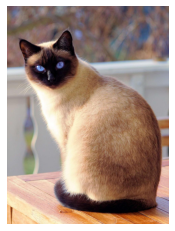

In [ ]:
im_org = Image.open('/content/drive/MyDrive/Colab Notebooks/Базы/Pytorch. Часть #2/Котик.jpg')
im_org = np.array(im_org)
plt.imshow(im_org)
plt.axis('off')
plt.show()

In [ ]:
pk = Image.open('/content/drive/MyDrive/Colab Notebooks/Базы/Pytorch. Часть #2/Котик.jpg')
pk = transform(pk)
k = vgg19.avgpool(pk.unsqueeze(0))
k.shape

torch.Size([1, 3, 7, 7])

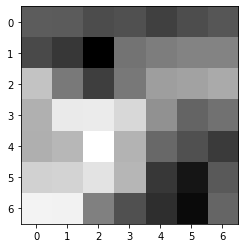

In [ ]:
plt.imshow(k.squeeze()[1].data.numpy(), cmap='gray')
plt.show()

In [ ]:
# Загружаем картинку

im_org = Image.open('/content/drive/MyDrive/Colab Notebooks/Базы/Pytorch. Часть #2/Котик.jpg') 

# Применяем нормализацию

im = transform(im_org).to(device)
print(im.shape)

torch.Size([3, 1280, 949])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


Метка класса: Siamese_cat - Вероятность: 0.329007
Метка класса: Egyptian_cat - Вероятность: 0.051519
Метка класса: weasel - Вероятность: 0.017238
Метка класса: lynx - Вероятность: 0.014156
Метка класса: cougar - Вероятность: 0.013297


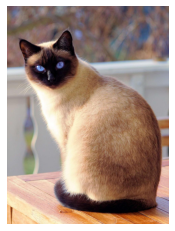

In [ ]:
# Пропустим через софтмакс выход с последнего слоя предобученной сети

probas = nn.Softmax()(vgg19(im.unsqueeze(0))).view(-1)

sortedOuputs = torch.argsort(probas, descending=True)

# Вывод 5 наиболее вероятных классов

for i in range(5):
    print("Метка класса: {:s} - Вероятность: {:4f}".format(
        idx2label[sortedOuputs[i]], probas[sortedOuputs[i]]))
    
plt.imshow(im_org)
plt.axis('off')
plt.show()

In [ ]:
# Обозначим переменные

config = SimpleNamespace()
config.content = '/content/drive/MyDrive/Colab Notebooks/Базы/Pytorch. Часть #2/Котик.jpg'
config.style1 = '/content/drive/MyDrive/Colab Notebooks/Базы/Pytorch. Часть #2/Кубизм.jpg'
config.style2 = '/content/drive/MyDrive/Colab Notebooks/Базы/Pytorch. Часть #2/Импрессионизм.jpg'
config.maxSize = 400
config.totalStep = 600
config.step = 10
config.sampleStep = 100
config.lr = .003 

In [ ]:
class PretrainedNet(nn.Module):
    def __init__(self):
        super(PretrainedNet, self).__init__()
        self.select = [0, 5, 7, 10, 15, 18]
        self.pretrainedNet = models.vgg19(pretrained=True).to(device)

    def forward(self, x):
        features = []
        output = x
        for layerIndex in range(len(self.pretrainedNet.features)):
          output = self.pretrainedNet.features[layerIndex](output)
          if layerIndex in self.select:
            features.append(output)
        return features

In [ ]:
def load_image(image_path, transform=None, maxSize=None, shape=None):

    image = Image.open(image_path)

    if maxSize:
        scale = maxSize / max(image.size)
        size = np.array(image.size) * scale
        image = image.resize(size.astype(int), Image.ANTIALIAS)

    if shape:
        image = image.resize(shape, Image.LANCZOS)

    if transform:
        image = transform(image).unsqueeze(0)

    return image.to(device)

In [ ]:
# Методы трансформирования изображения

transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                                     std=(0.229, 0.224, 0.225))])

In [ ]:
# Загружаем оригинал и стиль для картинок

content = load_image(config.content, transform, maxSize=config.maxSize)
style1 = load_image(config.style1, transform, shape=[content.size(2), content.size(3)])
style2 = load_image(config.style2, transform, shape=[content.size(2), content.size(3)])

In [ ]:
# Создаем место под тензор для конечной картинки

target = content.clone().requires_grad_(True)

In [ ]:
target.shape

torch.Size([1, 3, 400, 296])

In [ ]:
model = PretrainedNet().eval()
optimizer = torch.optim.Adam([target], lr=0.1)
contentCriteria = nn.MSELoss()

In [ ]:
for step in range(config.totalStep):
    targetFeatures = model.forward(target)
    contentFeatures = model.forward(content)
    styleFeatures1 = model.forward(style1)
    styleFeatures2 = model.forward(style2)
    
    styleLoss = 0
    contentLoss = 0

    for f1, f2, f3, f4 in zip(targetFeatures, contentFeatures, styleFeatures1, styleFeatures2):

        contentLoss += contentCriteria(f1, f2)

        _, c, h, w = f1.size()
        f1 = f1.reshape(c, h*w).to(device) 
        f3 = f3.reshape(c, h*w).to(device)
        f4 = f4.reshape(c, h*w).to(device)

        f1 = torch.mm(f1, f1.t()) 
        f3 = torch.mm(f3, f3.t())
        f4 = torch.mm(f4, f4.t())

        kf1 = 1 / 4 * (len(f1)*len(f3))**2
        kf2 = 1 / 4 * (len(f1)*len(f4))**2
        kf3 = 1 / (c * w * h)
        kf4 = 1 / (c * w * h)

        styleLoss += contentCriteria(f1,f3) * kf1 + contentCriteria(f1,f4) * kf2

    loss = styleLoss + contentLoss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (step+1) % config.step == 0:
        print('Шаг [{}/{}], Ошибка для оригинала: {:.4f}, Ошибка для стиля: {}' 
               .format(step+1, config.totalStep, contentLoss.item(), styleLoss.item()))

    if (step+1) % config.sampleStep == 0:
        img = target.clone().squeeze()
        img = img.clamp_(0, 1)
        torchvision.utils.save_image(img, 'output-{}.png'.format(step+1))

Шаг [10/600], Ошибка для оригинала: 101.8698, Ошибка для стиля: 2.056437268248055e+19
Шаг [20/600], Ошибка для оригинала: 110.6219, Ошибка для стиля: 1.8655734845870703e+19
Шаг [30/600], Ошибка для оригинала: 113.0314, Ошибка для стиля: 1.792536665493445e+19
Шаг [40/600], Ошибка для оригинала: 114.3271, Ошибка для стиля: 1.7580645570370863e+19
Шаг [50/600], Ошибка для оригинала: 115.5867, Ошибка для стиля: 1.7406957917554344e+19
Шаг [60/600], Ошибка для оригинала: 116.8016, Ошибка для стиля: 1.7312103049426108e+19
Шаг [70/600], Ошибка для оригинала: 117.7858, Ошибка для стиля: 1.7256644782432715e+19
Шаг [80/600], Ошибка для оригинала: 118.6718, Ошибка для стиля: 1.7221258100204372e+19
Шаг [90/600], Ошибка для оригинала: 119.3240, Ошибка для стиля: 1.719717219848631e+19
Шаг [100/600], Ошибка для оригинала: 119.8831, Ошибка для стиля: 1.7179831800604656e+19
Шаг [110/600], Ошибка для оригинала: 120.3920, Ошибка для стиля: 1.7166684940071338e+19
Шаг [120/600], Ошибка для оригинала: 120.831

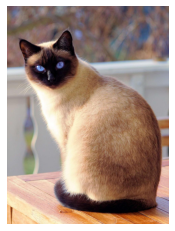

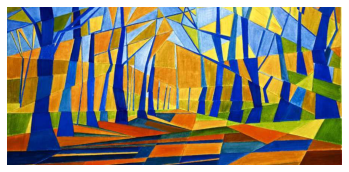

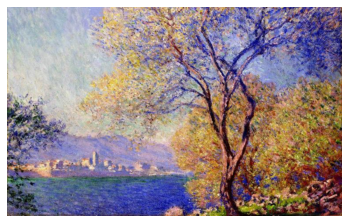

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


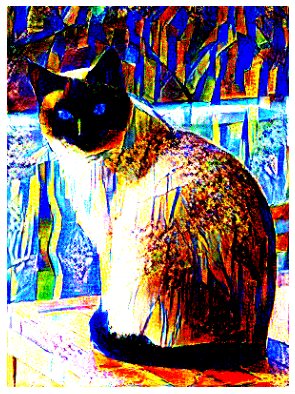

In [ ]:
# Выводим исходное изображение
content_img = Image.open(config.content)
plt.imshow(content_img)
plt.axis('off')
plt.show()

# Выводим изображение со стилем 1
style_img1 = Image.open(config.style1)
plt.imshow(style_img1)
plt.axis('off')
plt.show()

# Выводим изображение со стилем 2
style_img2 = Image.open(config.style2)
plt.imshow(style_img2)
plt.axis('off')
plt.show()

# Выводим изображение с перенесенным стилем
target_img = target.cpu().detach().numpy()[0].transpose(1,2,0)
plt.figure(figsize=(14,7))
plt.imshow(target_img)
plt.axis('off')
plt.show()